Hunter Bennett | Glass Lab | Kupffer Strains Project | 14 March 2023

Differential peak calling pipeline. Generates scatterplots describing pairwise peak comparisons and output file (via getDifferrentialExpression.pl) that is used to select peaks for motif analysis in future notebooks.

### Load packages, set plot parameters

In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
%matplotlib inline
import os
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

Set working directory

In [2]:
workingDirectory = '/home/h1bennet/strains_github/results/Figure2_ATAC/' # user will need to set own wd
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

Define custom functions

In [3]:
def read_annotated_peaks(path, filter_sex_unknown=True):
    '''This function imports an annotated homer peak file using
    pandas read_csv function. It also performes common preprocessing steps
    such as placing the peak IDs in the index and filtering so that
    only autosomal peaks are included. Also renames index to peakID.
       
       Accepts:
           path (str): path to expression file
           filter_sex_unkown (bool): filter unknown chromosomes
           and sex chromosomes - focus analysis on autosomal chr.
       
       Returns:
           df (pandas.Dataframe): genes by samples with annotation.
           mat (pandas.DataFrame): genes by samples without annotation.
       '''
    # import functions
    import pandas as pd

    df = pd.read_csv(path, sep='\t', index_col=0)

    # rename index
    df.index.rename('PeakID', inplace=True)
    # rename sample columns so they are shorter (can add .str.split('/').str[-1] to shorten even more
    df = df.rename(
        columns=dict(zip(df.iloc[:, 18:].columns.values,
                         pd.Series(df.iloc[:, 18:].columns.values).str.split(' Tag Count').str[0])))

    
    # filter unknown and sex chromosomes
    autosomes = ['chr1', 'chr2', 'chr3', 'chr4',
                 'chr5', 'chr6', 'chr7', 'chr8',
                 'chr9', 'chr10', 'chr11', 'chr12',
                 'chr13', 'chr14', 'chr15', 'chr16',
                 'chr17', 'chr18', 'chr19']

    df = df.loc[df.Chr.str.contains('|'.join(autosomes)), :]
      
    mat = df.iloc[:, 18:]
        
    return (df, mat)

def import_homer_diffpeak(depath, appath):
    '''This function takes in a getDiffExpression file created from raw tag counts
       and a peak tag file created with annotatePeaks
       and processes the files so that they contain the same set of genes and can be
       used for data visualization and analysis
       Accepts:
           depath (str): path to getDiffExpression file
           appath (str): path to annotatePeaks file
       Returns:
           de (pandas.DataFrame): modified getDiffExpression file
           ge (pandas.DataFrame): modified annotatePeaks,
           ge_mat (pandas.DataFrame): annotatePeaks file without annotation
           ge_mat_quatn (pandas.DataFrame) : annotatePeaks file without annotation
           and quantile normalized
       '''
    # import packages
    import pandas as pd
    import numpy as np

    # set autosomes for filtering
    autosomes = ['chr1', 'chr2', 'chr3', 'chr4',
                 'chr5', 'chr6', 'chr7', 'chr8',
                 'chr9', 'chr10', 'chr11', 'chr12',
                 'chr13', 'chr14', 'chr15', 'chr16',
                 'chr17', 'chr18', 'chr19']

    # import differential gene expression
    de = pd.read_csv(depath, sep='\t', index_col=0)
    de.index.rename('PeakID', inplace=True)
    de = de.loc[de.Chr.str.contains('|'.join(autosomes)), :]


    # import ge file
    ap = pd.read_csv(appath, sep='\t', index_col=0)
    ap.index.rename('PeakID', inplace=True)

    # select ge transcripts that are in diff_gene
    print('annotatePeaks all peaks', ap.shape)
    print('getDiffExpression selected transcripts', de.shape)
    ap = ap.loc[de.index.tolist(), :]
    print('annotatePeaks selected peaks', ap.shape)


    # return files
    return (de, ap, ap.iloc[:, 18:]) # also return count matrix without annotation

def pull_comparisons_get_diff(diff_gene, seq_type='Repeat'):
    '''This function pulls out comparisons from a diff gene file with multiple comparision groups
    and returns a dict of pandas DataFrames with one comparison each.

    Accepts:
        diff_gene (pandas.DataFrame): diff gene file processed to have
        genes as index and column of RefSeqIDs titled RepeatID
        seq_type (str): Repeat|Peak type of annotation file. repeat for RNA
        peak for ChIP/ATAC

    Returns:
    comp_dict (dict): dictionary of 1 pandas Data Frame per each comparison
    ''' 


    # import packages
    import pandas as pd
    import re
    
    if seq_type=='Repeat':
        # extract groups
        def subset_get_diff(diff_gene, comp):
            return diff_gene.loc[:, [seq_type+'ID',
                                     comp + ' Log2 Fold Change',
                                     comp + ' p-value',
                                     comp + ' adj. p-value']]

    if seq_type=='Peak':
        # exract groups
        def subset_get_diff(diff_gene, comp):
             return diff_gene.loc[:, ['Chr', 'Start', 'End',
                                      'Annotation',
                                      'Gene Name',
                                      'Distance to TSS',
                                       comp + ' Log2 Fold Change',
                                       comp + ' p-value',
                                       comp + ' adj. p-value']]
    
    comp_dict = {}
    pattern='(\w* vs. \w*).*'
    for col in diff_gene.columns.values:
        m = re.search(string=col, pattern=pattern)
        if m:
            df = subset_get_diff(diff_gene, m.group(1))
            if seq_type=='Repeat':
                df.columns = ['RepeatID', 'log2fc', 'pval', 'adj_pval']
            if seq_type=='Peak':
                df['location'] = df.Chr.astype(str)+':'+df.Start.astype(str)+'-'+df.End.astype(str)
                df.columns = ['Chr', 'Start', 'End',
                              'Annotation', 'gene', 'TSS_dist',
                              'log2fc', 'pval', 'adj_pval', 'location']
    
            comp_dict[re.sub('G0[0-9]_', '', m.group(1))] = df
    
    return comp_dict

In [4]:
#### PLOTTING PARAMETERS FOR MANUSCRIPT ####
# # get matplotlib to save readable fonts
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['savefig.dpi'] = 500


# line widths
matplotlib.rcParams['axes.linewidth'] = 1
matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1

# adjust defualt color for plots to black
# normal default is a dark gray
COLOR = 'black'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR
matplotlib.rcParams['axes.edgecolor'] = COLOR

#### PLOT PARAMETERS FOR THIS PLOT ####

### Read in raw peak tag count files

In [5]:
# import annotation file
df, mat = read_annotated_peaks('https://zenodo.org/record/7829622/files/idr_peaks_atac_raw.txt') # replace with Zenodo URL

df.to_csv('./idr_peaks_atac_raw.txt', sep='\t')

### Calculate differential peaks with DESeq2

Run the following in the command line (requires homer installation with DESeq2)

    getDiffExpression.pl \
    ./idr_peaks_atac_raw.txt \
    aj aj aj aj \
    balbcj balbcj balbcj balbcj \
    c57bl6j c57bl6j c57bl6j c57bl6j \
    -AvsA -peaks > ./diff_output.txt

### Plotting differrential peaks
We will need to create a filtered normalized tag matrix for plotting differentially expressed genes

Import differential peaks

In [6]:
diff_peak, peaks, peak_mat = import_homer_diffpeak(
    './diff_output.txt',
    './idr_peaks_atac_norm.txt')

# create dictionary of sub data-frames for each comparison
comp_dict = pull_comparisons_get_diff(diff_peak, seq_type='Peak')

annotatePeaks all peaks (84264, 30)
getDiffExpression selected transcripts (84264, 39)
annotatePeaks selected peaks (84264, 30)


Calculate average tags for each peak

In [7]:
peak_mat['aj_avg'] = peak_mat.loc[:, peak_mat.columns.str.contains('aj')].mean(1)
peak_mat['balbcj_avg'] = peak_mat.loc[:, peak_mat.columns.str.contains('balbcj')].mean(1)
peak_mat['c57bl6j_avg'] = peak_mat.loc[:, peak_mat.columns.str.contains('c57bl6j')].mean(1)

Set plot parameters

In [8]:
comps = ['aj vs. balbcj',
         'aj vs. c57bl6j',
         'balbcj vs. c57bl6j']

labels = [['A/J\nlog2(tag counts + 1)',
           'BALB/cJ\nlog2(tag counts + 1)'],
          ['A/J\nlog2(tag counts + 1)',
           'C57BL/6J\nlog2(tag counts + 1)'],
          ['BALB/cJ\nlog2(tag counts + 1)',
           'C57BL/6J\nlog2(tag counts + 1)']]

groups = [[peak_mat.columns.str.contains('AJ_Kupffer_Control'),
           peak_mat.columns.str.contains('BALBcJ_Kupffer_Control')],
         [peak_mat.columns.str.contains('AJ_Kupffer_Control'),
          peak_mat.columns.str.contains('C57_Kupffer_Control')],
         [peak_mat.columns.str.contains('BALBcJ_Kupffer_Control'),
          peak_mat.columns.str.contains('C57_Kupffer_Control')]]

cols = []
for i in groups:
    union = i[0] | i[1]
    cols.append(union)

# set plotting thresholds
pthresh = 0.05
lfcthresh = (1,2)
dotsize = 3
ax_max = 12
n_yticks = 5
ytickstep = 3

colors = [['#969696', '#6baed6', '#fd8d3c'],
          ['#969696', '#6baed6', '#fd8d3c'],
          ['#969696', '#6baed6', '#fd8d3c']]
    
dotsize=0.5
tag_thresh=2
fontsize=8

Plot with log2fc thresholds, nonspecific coloring for log2fc thresholds

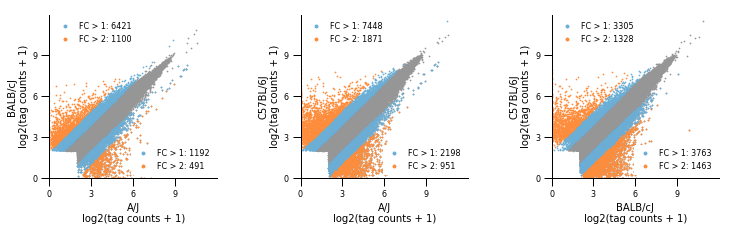

In [9]:

fig, axs = plt.subplots(1,3, figsize=(12,3))
plt.subplots_adjust(wspace=0.5)

i=0

for key, col, group, labs, color, ax in zip(comps, cols, groups, labels, colors, axs.reshape(-1)):
    
    de = comp_dict[key]
    de['logtpm'] = np.log2(peak_mat.loc[:, col].mean(1)+1)
    de['log10p'] = -np.log10(de.adj_pval + 10**(-50))
    de['g0_mean'] = np.log2(peak_mat.loc[:, group[0]].mean(1)+1)
    de['g1_mean'] = np.log2(peak_mat.loc[:, group[1]].mean(1)+1)
    de['unadj_log2fc'] = np.log2((peak_mat.loc[:, group[1]].mean(1)+1)/((peak_mat.loc[:, group[0]].mean(1))+1))
    
    # filter lowly genes
    de = de.loc[(de.g0_mean > tag_thresh) | (de.g1_mean > tag_thresh)]
       
    # plot group by group scatter:
    de_nonsig = de.reindex(de.index[(np.abs(de.unadj_log2fc <= lfcthresh[0]))])
    de_sig_fc1 = de.reindex(de.index[(np.abs(de.unadj_log2fc) >= lfcthresh[0]) & (np.abs(de.unadj_log2fc) < lfcthresh[1])])
    de_sig_fc2 = de.reindex(de.index[(np.abs(de.unadj_log2fc) >= lfcthresh[1])])
    
    for df, c, z in zip([de_nonsig, de_sig_fc1, de_sig_fc2],
                     color,
                     np.arange(len(color))[::-1]*-5): # set zorder, need to be ascending negative because axis line should be in front at 0
        ax.scatter(
            x=df.g0_mean,
            y=df.g1_mean,
            c=c,
            s=dotsize,
            zorder=z)
        
    # Hide the right and top spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)
    
    # set axis labels
    ax.set_xlabel(labs[0], fontsize=fontsize+2)
    ax.set_ylabel(labs[1], fontsize=fontsize+2)
    
    #set max and min
    ax.set_xlim([0,ax_max])
    ax.set_ylim([0,ax_max])
    

    # set ticks
    ax.tick_params(width=1, length=fontsize)
    ax.set_xticks(np.arange(0,ax_max,ytickstep))
    ax.set_xticklabels(np.arange(0,ax_max,ytickstep), fontsize=fontsize)
    ax.set_yticks(np.arange(0,ax_max,ytickstep))
    ax.set_yticklabels(np.arange(0,ax_max,ytickstep), fontsize=fontsize)
    
    # make legend
    g1_legend_elements = [Line2D([0], [0], marker='o', color='w',
                                 label='FC > %i: %i' % (lfcthresh[0], (de_sig_fc1.unadj_log2fc > 0).sum()),
                                 markerfacecolor=color[1], markersize=5),
                        Line2D([0], [0], marker='o', color='w',
                                 label='FC > %i: %i' % (lfcthresh[1], (de_sig_fc2.unadj_log2fc > 0).sum()),
                                 markerfacecolor=color[2], markersize=5)]
    
    g2_legend_elements = [Line2D([0], [0], marker='o', color='w',
                                 label='FC > %i: %i' % (lfcthresh[0], (de_sig_fc1.unadj_log2fc < 0).sum()),
                                 markerfacecolor=color[1], markersize=5),
                        Line2D([0], [0], marker='o', color='w',
                                 label='FC > %i: %i' % (lfcthresh[1], (de_sig_fc2.unadj_log2fc < 0).sum()),
                                 markerfacecolor=color[2], markersize=5)]
    
    legend1 = axs[i].legend(handles=g1_legend_elements,
                         fontsize=fontsize, loc='upper left',
                         frameon=True, facecolor='white', framealpha=1, edgecolor='white')
    
    legend2 = axs[i].legend(handles=g2_legend_elements,
                        fontsize=fontsize, loc='lower right',
                        frameon=True, facecolor='white', framealpha=1, edgecolor='white')
    
    axs[i].add_artist(legend1)

    i += 1